# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip 'processed-celeba-small.zip'

In [2]:
data_dir = 'processed-celeba-small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    data_loader = DataLoader(dataset, batch_size=batch_size)
    return data_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

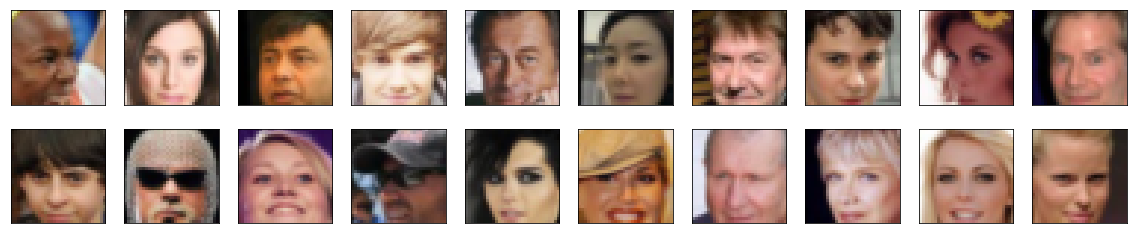

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9529)
Max:  tensor(0.9451)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv1 = self.conv(3, conv_dim, batch_norm=False)
        self.conv2 = self.conv(conv_dim, conv_dim*2, batch_norm=True)
        self.conv3 = self.conv(conv_dim*2, conv_dim*4, batch_norm=True)
        self.conv4 = self.conv(conv_dim*4, conv_dim*8, batch_norm=True)
        self.linear_in = conv_dim*8*2*2
        self.linear = nn.Linear(self.linear_in, 1)
        self.relu = nn.LeakyReLU()

    def conv(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
        layers = []
        convolution = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False)
        layers.append(convolution)
        if batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        return nn.Sequential(*layers)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        batch_size = x.shape[0]
        # define feedforward behavior
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = x.view(batch_size, self.linear_in)
        x = self.linear(x)
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [14]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.linear = nn.Linear(z_size, conv_dim*8*2*2)
        self.deconv1 = self.deconv(conv_dim*8, conv_dim*4, batch_norm=False)
        self.deconv2 = self.deconv(conv_dim*4, conv_dim*2, batch_norm=False)
        self.deconv3 = self.deconv(conv_dim*2, conv_dim, batch_norm=False)
        self.deconv4 = self.deconv(conv_dim, 3, batch_norm=True)
        self.relu = nn.LeakyReLU()

    def deconv(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
        layers = []
        convolution = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False)
        layers.append(convolution)
        if batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.relu(self.linear(x))
        x = x.view(-1, self.conv_dim*8, 2, 2)
        x = self.relu(self.deconv1(x))
        x = self.relu(self.deconv2(x))
        x = self.relu(self.deconv3(x))
        x = torch.tanh(self.deconv4(x))
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [15]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if 'Conv' in classname or 'Linear' in classname:
        nn.init.normal_(m.weight.data, 0, std=0.02)
        if m.bias is not None:
            m.bias.data.zero_()
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [17]:
# Define model hyperparams
d_conv_dim = 16
g_conv_dim = 16
z_size = 12

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear): Linear(in_features=512, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

Generator(
  (linear): Linear(in_features=12, out_features=512, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), 

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [19]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.shape[0]
    target = torch.ones(batch_size)
    if smooth:
        target = target * 0.9
    if train_on_gpu:
        target = target.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), target)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.shape[0]
    target = torch.zeros(batch_size)
    if train_on_gpu:
        target = target.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), target)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [20]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr=0.0001)
g_optimizer = optim.Adam(G.parameters(), lr=0.0001)

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [21]:
def generate_z(batch_size, z_size):
    z = torch.from_numpy(np.random.uniform(-1, 1, size=(batch_size, z_size))).float()
    if train_on_gpu:
        z = z.cuda()
    return z


def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            if train_on_gpu:
                real_images = real_images.cuda()
                
            # 1. Train the discriminator on real and fake images
            D.zero_grad()
            d_real_out = D(real_images)
            fake_images = G(generate_z(batch_size, z_size))
            d_fake_out = D(fake_images)
            
            d_loss = real_loss(d_real_out) + fake_loss(d_fake_out)
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            G.zero_grad()
            fake_images = G(generate_z(batch_size, z_size))
            d_fake_out = D(fake_images)
            g_loss = real_loss(d_fake_out)
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [22]:
# set number of epochs 
n_epochs = 50


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 1.4477 | g_loss: 0.7552
Epoch [    1/   50] | d_loss: 0.7503 | g_loss: 1.3243
Epoch [    1/   50] | d_loss: 0.4040 | g_loss: 2.2231
Epoch [    1/   50] | d_loss: 0.1683 | g_loss: 2.9705
Epoch [    1/   50] | d_loss: 0.1552 | g_loss: 2.9603
Epoch [    1/   50] | d_loss: 0.0742 | g_loss: 3.5059
Epoch [    1/   50] | d_loss: 0.0817 | g_loss: 3.6016
Epoch [    1/   50] | d_loss: 0.0462 | g_loss: 3.9986
Epoch [    1/   50] | d_loss: 0.0462 | g_loss: 4.0903
Epoch [    1/   50] | d_loss: 0.0563 | g_loss: 4.0545
Epoch [    1/   50] | d_loss: 0.0338 | g_loss: 4.2231
Epoch [    1/   50] | d_loss: 0.0377 | g_loss: 4.5471
Epoch [    1/   50] | d_loss: 0.0194 | g_loss: 4.6768
Epoch [    1/   50] | d_loss: 0.0148 | g_loss: 5.1388
Epoch [    1/   50] | d_loss: 0.0263 | g_loss: 5.0956
Epoch [    1/   50] | d_loss: 0.0113 | g_loss: 5.2131
Epoch [    1/   50] | d_loss: 0.0133 | g_loss: 5.2038
Epoch [    1/   50] | d_loss: 0.0081 | g_loss: 5.6977
Epoch [    1/   50] | d_loss

Epoch [    3/   50] | d_loss: 0.0318 | g_loss: 3.4311
Epoch [    3/   50] | d_loss: 0.0158 | g_loss: 8.5872
Epoch [    3/   50] | d_loss: 0.0144 | g_loss: 4.6125
Epoch [    3/   50] | d_loss: 0.0668 | g_loss: 4.5313
Epoch [    3/   50] | d_loss: 0.5069 | g_loss: 3.0135
Epoch [    3/   50] | d_loss: 0.0442 | g_loss: 4.1319
Epoch [    3/   50] | d_loss: 0.2959 | g_loss: 1.9274
Epoch [    3/   50] | d_loss: 0.0732 | g_loss: 4.0240
Epoch [    3/   50] | d_loss: 0.2266 | g_loss: 5.2962
Epoch [    3/   50] | d_loss: 0.0500 | g_loss: 4.1622
Epoch [    3/   50] | d_loss: 0.0791 | g_loss: 4.5037
Epoch [    3/   50] | d_loss: 0.2410 | g_loss: 3.7793
Epoch [    3/   50] | d_loss: 0.0503 | g_loss: 5.7324
Epoch [    3/   50] | d_loss: 0.1874 | g_loss: 5.2683
Epoch [    3/   50] | d_loss: 0.4232 | g_loss: 4.9624
Epoch [    3/   50] | d_loss: 0.0596 | g_loss: 6.2540
Epoch [    3/   50] | d_loss: 0.1131 | g_loss: 4.3288
Epoch [    3/   50] | d_loss: 0.1184 | g_loss: 5.8637
Epoch [    3/   50] | d_loss

Epoch [    6/   50] | d_loss: 0.0805 | g_loss: 5.7414
Epoch [    6/   50] | d_loss: 0.0834 | g_loss: 3.4286
Epoch [    6/   50] | d_loss: 0.0401 | g_loss: 5.3517
Epoch [    6/   50] | d_loss: 0.0325 | g_loss: 7.0303
Epoch [    6/   50] | d_loss: 0.1967 | g_loss: 4.3797
Epoch [    6/   50] | d_loss: 0.0271 | g_loss: 3.8979
Epoch [    6/   50] | d_loss: 0.1417 | g_loss: 5.3023
Epoch [    6/   50] | d_loss: 0.0283 | g_loss: 4.4545
Epoch [    6/   50] | d_loss: 0.2762 | g_loss: 5.9285
Epoch [    6/   50] | d_loss: 0.1928 | g_loss: 7.1808
Epoch [    6/   50] | d_loss: 0.0691 | g_loss: 4.8135
Epoch [    6/   50] | d_loss: 0.2955 | g_loss: 2.8862
Epoch [    6/   50] | d_loss: 0.0546 | g_loss: 4.1433
Epoch [    6/   50] | d_loss: 0.0967 | g_loss: 3.3852
Epoch [    6/   50] | d_loss: 0.0040 | g_loss: 6.5276
Epoch [    6/   50] | d_loss: 0.0477 | g_loss: 5.9353
Epoch [    6/   50] | d_loss: 0.2226 | g_loss: 5.7969
Epoch [    6/   50] | d_loss: 0.0408 | g_loss: 3.3057
Epoch [    6/   50] | d_loss

Epoch [    9/   50] | d_loss: 0.0810 | g_loss: 4.6277
Epoch [    9/   50] | d_loss: 0.0384 | g_loss: 9.3229
Epoch [    9/   50] | d_loss: 0.2051 | g_loss: 6.4393
Epoch [    9/   50] | d_loss: 0.0749 | g_loss: 3.4574
Epoch [    9/   50] | d_loss: 0.0243 | g_loss: 7.6937
Epoch [    9/   50] | d_loss: 0.0275 | g_loss: 6.7352
Epoch [    9/   50] | d_loss: 0.0027 | g_loss: 11.7404
Epoch [    9/   50] | d_loss: 0.0434 | g_loss: 7.1712
Epoch [    9/   50] | d_loss: 0.0111 | g_loss: 1.7988
Epoch [    9/   50] | d_loss: 0.0256 | g_loss: 4.3225
Epoch [    9/   50] | d_loss: 0.3158 | g_loss: 8.5526
Epoch [    9/   50] | d_loss: 0.0364 | g_loss: 5.7613
Epoch [    9/   50] | d_loss: 0.0299 | g_loss: 6.1215
Epoch [    9/   50] | d_loss: 0.0222 | g_loss: 6.4409
Epoch [    9/   50] | d_loss: 0.0107 | g_loss: 3.7249
Epoch [    9/   50] | d_loss: 0.1369 | g_loss: 4.2324
Epoch [    9/   50] | d_loss: 0.0142 | g_loss: 4.2493
Epoch [    9/   50] | d_loss: 0.0339 | g_loss: 4.9987
Epoch [    9/   50] | d_los

Epoch [   11/   50] | d_loss: 0.0330 | g_loss: 5.6202
Epoch [   11/   50] | d_loss: 0.0425 | g_loss: 6.1217
Epoch [   11/   50] | d_loss: 0.0628 | g_loss: 4.4561
Epoch [   11/   50] | d_loss: 0.1171 | g_loss: 8.3080
Epoch [   11/   50] | d_loss: 0.0055 | g_loss: 6.0501
Epoch [   11/   50] | d_loss: 0.1368 | g_loss: 3.6900
Epoch [   11/   50] | d_loss: 0.1165 | g_loss: 3.5906
Epoch [   11/   50] | d_loss: 0.0789 | g_loss: 3.1433
Epoch [   11/   50] | d_loss: 0.0688 | g_loss: 5.0779
Epoch [   11/   50] | d_loss: 0.0846 | g_loss: 5.2529
Epoch [   11/   50] | d_loss: 0.2456 | g_loss: 6.5984
Epoch [   11/   50] | d_loss: 0.0359 | g_loss: 4.2991
Epoch [   11/   50] | d_loss: 0.0097 | g_loss: 3.7128
Epoch [   11/   50] | d_loss: 0.0026 | g_loss: 6.2316
Epoch [   11/   50] | d_loss: 0.2032 | g_loss: 5.0946
Epoch [   11/   50] | d_loss: 0.0528 | g_loss: 5.5552
Epoch [   11/   50] | d_loss: 0.1978 | g_loss: 6.6518
Epoch [   11/   50] | d_loss: 0.1641 | g_loss: 3.8795
Epoch [   12/   50] | d_loss

Epoch [   14/   50] | d_loss: 0.2393 | g_loss: 3.0881
Epoch [   14/   50] | d_loss: 0.0966 | g_loss: 3.9376
Epoch [   14/   50] | d_loss: 0.0348 | g_loss: 5.9652
Epoch [   14/   50] | d_loss: 0.0101 | g_loss: 5.5736
Epoch [   14/   50] | d_loss: 0.0297 | g_loss: 3.2022
Epoch [   14/   50] | d_loss: 0.0100 | g_loss: 2.5918
Epoch [   14/   50] | d_loss: 0.5249 | g_loss: 4.1945
Epoch [   14/   50] | d_loss: 0.2096 | g_loss: 4.0704
Epoch [   14/   50] | d_loss: 0.1182 | g_loss: 7.1167
Epoch [   14/   50] | d_loss: 0.0978 | g_loss: 6.2282
Epoch [   14/   50] | d_loss: 0.0448 | g_loss: 3.7630
Epoch [   14/   50] | d_loss: 0.0656 | g_loss: 5.5321
Epoch [   14/   50] | d_loss: 0.0148 | g_loss: 5.5513
Epoch [   14/   50] | d_loss: 0.3073 | g_loss: 4.0760
Epoch [   14/   50] | d_loss: 0.0615 | g_loss: 9.8208
Epoch [   14/   50] | d_loss: 0.0217 | g_loss: 7.0769
Epoch [   14/   50] | d_loss: 0.0500 | g_loss: 3.8451
Epoch [   14/   50] | d_loss: 0.0640 | g_loss: 5.7177
Epoch [   14/   50] | d_loss

Epoch [   17/   50] | d_loss: 0.0621 | g_loss: 8.4381
Epoch [   17/   50] | d_loss: 0.0797 | g_loss: 3.3650
Epoch [   17/   50] | d_loss: 1.0771 | g_loss: 5.6650
Epoch [   17/   50] | d_loss: 0.2620 | g_loss: 5.3740
Epoch [   17/   50] | d_loss: 0.0261 | g_loss: 8.1860
Epoch [   17/   50] | d_loss: 0.0317 | g_loss: 6.3303
Epoch [   17/   50] | d_loss: 0.2495 | g_loss: 3.3748
Epoch [   17/   50] | d_loss: 0.0487 | g_loss: 7.7778
Epoch [   17/   50] | d_loss: 0.1078 | g_loss: 6.5466
Epoch [   17/   50] | d_loss: 0.9658 | g_loss: 4.1407
Epoch [   17/   50] | d_loss: 0.1439 | g_loss: 5.5296
Epoch [   17/   50] | d_loss: 0.0149 | g_loss: 5.6191
Epoch [   17/   50] | d_loss: 0.1446 | g_loss: 7.3926
Epoch [   17/   50] | d_loss: 0.2423 | g_loss: 4.8252
Epoch [   17/   50] | d_loss: 0.0883 | g_loss: 6.2558
Epoch [   17/   50] | d_loss: 0.0428 | g_loss: 3.1079
Epoch [   17/   50] | d_loss: 0.6931 | g_loss: 8.3815
Epoch [   17/   50] | d_loss: 0.1009 | g_loss: 6.5812
Epoch [   17/   50] | d_loss

Epoch [   19/   50] | d_loss: 0.2475 | g_loss: 1.7938
Epoch [   19/   50] | d_loss: 0.4862 | g_loss: 7.0813
Epoch [   19/   50] | d_loss: 0.0717 | g_loss: 4.1812
Epoch [   19/   50] | d_loss: 0.0889 | g_loss: 5.9468
Epoch [   19/   50] | d_loss: 0.3947 | g_loss: 4.2450
Epoch [   19/   50] | d_loss: 0.1081 | g_loss: 6.2566
Epoch [   19/   50] | d_loss: 0.3157 | g_loss: 3.1872
Epoch [   19/   50] | d_loss: 0.2303 | g_loss: 5.2890
Epoch [   19/   50] | d_loss: 0.0355 | g_loss: 4.1805
Epoch [   19/   50] | d_loss: 0.0525 | g_loss: 3.5071
Epoch [   19/   50] | d_loss: 0.2650 | g_loss: 7.3386
Epoch [   19/   50] | d_loss: 0.7441 | g_loss: 4.3993
Epoch [   19/   50] | d_loss: 0.1502 | g_loss: 3.7711
Epoch [   19/   50] | d_loss: 0.0201 | g_loss: 7.9868
Epoch [   19/   50] | d_loss: 0.3341 | g_loss: 3.1719
Epoch [   19/   50] | d_loss: 0.0428 | g_loss: 6.8228
Epoch [   19/   50] | d_loss: 0.0538 | g_loss: 3.9294
Epoch [   19/   50] | d_loss: 0.0663 | g_loss: 6.5782
Epoch [   20/   50] | d_loss

Epoch [   22/   50] | d_loss: 0.1137 | g_loss: 5.5912
Epoch [   22/   50] | d_loss: 0.2598 | g_loss: 3.4189
Epoch [   22/   50] | d_loss: 0.0190 | g_loss: 2.6909
Epoch [   22/   50] | d_loss: 0.1363 | g_loss: 5.7351
Epoch [   22/   50] | d_loss: 0.4632 | g_loss: 6.5437
Epoch [   22/   50] | d_loss: 0.1921 | g_loss: 2.3785
Epoch [   22/   50] | d_loss: 0.3917 | g_loss: 0.9736
Epoch [   22/   50] | d_loss: 0.2060 | g_loss: 4.2506
Epoch [   22/   50] | d_loss: 0.4205 | g_loss: 6.6353
Epoch [   22/   50] | d_loss: 0.5975 | g_loss: 3.6266
Epoch [   22/   50] | d_loss: 0.1715 | g_loss: 2.4634
Epoch [   22/   50] | d_loss: 1.4255 | g_loss: 5.4013
Epoch [   22/   50] | d_loss: 0.4995 | g_loss: 2.2700
Epoch [   22/   50] | d_loss: 0.0800 | g_loss: 2.9251
Epoch [   22/   50] | d_loss: 0.0448 | g_loss: 5.3020
Epoch [   22/   50] | d_loss: 0.0500 | g_loss: 7.2154
Epoch [   22/   50] | d_loss: 0.1435 | g_loss: 5.7116
Epoch [   22/   50] | d_loss: 0.7335 | g_loss: 5.7178
Epoch [   22/   50] | d_loss

Epoch [   25/   50] | d_loss: 0.2176 | g_loss: 4.0941
Epoch [   25/   50] | d_loss: 0.0509 | g_loss: 5.7367
Epoch [   25/   50] | d_loss: 0.2418 | g_loss: 4.2763
Epoch [   25/   50] | d_loss: 0.0320 | g_loss: 2.2908
Epoch [   25/   50] | d_loss: 0.1675 | g_loss: 5.2725
Epoch [   25/   50] | d_loss: 0.2813 | g_loss: 2.6875
Epoch [   25/   50] | d_loss: 0.0301 | g_loss: 5.5153
Epoch [   25/   50] | d_loss: 0.0259 | g_loss: 4.6038
Epoch [   25/   50] | d_loss: 0.1068 | g_loss: 6.1324
Epoch [   25/   50] | d_loss: 0.5353 | g_loss: 2.1460
Epoch [   25/   50] | d_loss: 0.0909 | g_loss: 2.9939
Epoch [   25/   50] | d_loss: 0.0456 | g_loss: 3.5200
Epoch [   25/   50] | d_loss: 0.1448 | g_loss: 3.7741
Epoch [   25/   50] | d_loss: 0.2063 | g_loss: 6.3683
Epoch [   25/   50] | d_loss: 0.1133 | g_loss: 5.7432
Epoch [   25/   50] | d_loss: 0.0481 | g_loss: 3.3027
Epoch [   25/   50] | d_loss: 0.2809 | g_loss: 5.4697
Epoch [   25/   50] | d_loss: 0.0741 | g_loss: 3.2524
Epoch [   25/   50] | d_loss

Epoch [   27/   50] | d_loss: 0.1179 | g_loss: 3.2492
Epoch [   27/   50] | d_loss: 0.1530 | g_loss: 5.0768
Epoch [   27/   50] | d_loss: 0.0241 | g_loss: 6.6710
Epoch [   27/   50] | d_loss: 0.1480 | g_loss: 3.1580
Epoch [   27/   50] | d_loss: 0.0353 | g_loss: 6.2255
Epoch [   27/   50] | d_loss: 0.0492 | g_loss: 7.4076
Epoch [   27/   50] | d_loss: 0.1032 | g_loss: 3.7989
Epoch [   27/   50] | d_loss: 0.1098 | g_loss: 8.5357
Epoch [   27/   50] | d_loss: 0.0347 | g_loss: 4.6923
Epoch [   27/   50] | d_loss: 0.6802 | g_loss: 3.9814
Epoch [   27/   50] | d_loss: 0.6693 | g_loss: 7.0963
Epoch [   27/   50] | d_loss: 0.0285 | g_loss: 4.1320
Epoch [   27/   50] | d_loss: 0.0622 | g_loss: 5.1888
Epoch [   27/   50] | d_loss: 0.0237 | g_loss: 3.3803
Epoch [   27/   50] | d_loss: 0.9959 | g_loss: 6.4020
Epoch [   27/   50] | d_loss: 0.3648 | g_loss: 1.4686
Epoch [   27/   50] | d_loss: 0.1516 | g_loss: 3.7336
Epoch [   27/   50] | d_loss: 0.0852 | g_loss: 7.9680
Epoch [   28/   50] | d_loss

Epoch [   30/   50] | d_loss: 0.2433 | g_loss: 4.4667
Epoch [   30/   50] | d_loss: 1.3793 | g_loss: 5.1293
Epoch [   30/   50] | d_loss: 0.2610 | g_loss: 3.1203
Epoch [   30/   50] | d_loss: 0.4468 | g_loss: 6.3874
Epoch [   30/   50] | d_loss: 0.0584 | g_loss: 5.2075
Epoch [   30/   50] | d_loss: 0.0238 | g_loss: 8.0697
Epoch [   30/   50] | d_loss: 0.2023 | g_loss: 7.3307
Epoch [   30/   50] | d_loss: 0.1723 | g_loss: 7.1323
Epoch [   30/   50] | d_loss: 0.3462 | g_loss: 3.9343
Epoch [   30/   50] | d_loss: 0.3105 | g_loss: 4.5646
Epoch [   30/   50] | d_loss: 0.0756 | g_loss: 3.8065
Epoch [   30/   50] | d_loss: 0.0470 | g_loss: 11.1446
Epoch [   30/   50] | d_loss: 0.1038 | g_loss: 5.3743
Epoch [   30/   50] | d_loss: 0.2691 | g_loss: 6.6830
Epoch [   30/   50] | d_loss: 0.7313 | g_loss: 3.8635
Epoch [   30/   50] | d_loss: 0.0368 | g_loss: 5.4827
Epoch [   30/   50] | d_loss: 0.0794 | g_loss: 2.9172
Epoch [   30/   50] | d_loss: 0.0964 | g_loss: 5.1902
Epoch [   30/   50] | d_los

Epoch [   33/   50] | d_loss: 0.0092 | g_loss: 3.4725
Epoch [   33/   50] | d_loss: 0.1266 | g_loss: 6.1560
Epoch [   33/   50] | d_loss: 0.2407 | g_loss: 4.4406
Epoch [   33/   50] | d_loss: 0.4686 | g_loss: 7.0629
Epoch [   33/   50] | d_loss: 0.6886 | g_loss: 7.0894
Epoch [   33/   50] | d_loss: 0.0382 | g_loss: 4.3000
Epoch [   33/   50] | d_loss: 0.6566 | g_loss: 4.8695
Epoch [   33/   50] | d_loss: 0.0335 | g_loss: 5.3010
Epoch [   33/   50] | d_loss: 0.3919 | g_loss: 8.0500
Epoch [   33/   50] | d_loss: 0.0645 | g_loss: 2.6372
Epoch [   33/   50] | d_loss: 0.0419 | g_loss: 6.6111
Epoch [   33/   50] | d_loss: 0.0997 | g_loss: 2.4709
Epoch [   33/   50] | d_loss: 0.0951 | g_loss: 4.2146
Epoch [   33/   50] | d_loss: 0.0232 | g_loss: 6.0045
Epoch [   33/   50] | d_loss: 0.1966 | g_loss: 4.5973
Epoch [   33/   50] | d_loss: 0.0941 | g_loss: 4.2302
Epoch [   33/   50] | d_loss: 0.0749 | g_loss: 2.2715
Epoch [   33/   50] | d_loss: 0.0350 | g_loss: 8.2341
Epoch [   33/   50] | d_loss

Epoch [   35/   50] | d_loss: 0.0881 | g_loss: 7.1407
Epoch [   35/   50] | d_loss: 0.1253 | g_loss: 7.2574
Epoch [   35/   50] | d_loss: 0.1107 | g_loss: 6.6160
Epoch [   35/   50] | d_loss: 0.0132 | g_loss: 4.9820
Epoch [   35/   50] | d_loss: 0.0628 | g_loss: 4.4703
Epoch [   35/   50] | d_loss: 0.1913 | g_loss: 5.1834
Epoch [   35/   50] | d_loss: 0.0175 | g_loss: 2.9289
Epoch [   35/   50] | d_loss: 0.1520 | g_loss: 7.0042
Epoch [   35/   50] | d_loss: 0.1398 | g_loss: 5.0170
Epoch [   35/   50] | d_loss: 0.4275 | g_loss: 4.9537
Epoch [   35/   50] | d_loss: 0.4363 | g_loss: 6.0800
Epoch [   35/   50] | d_loss: 0.4099 | g_loss: 5.1159
Epoch [   35/   50] | d_loss: 0.2740 | g_loss: 2.7237
Epoch [   35/   50] | d_loss: 0.0235 | g_loss: 6.4437
Epoch [   35/   50] | d_loss: 0.1060 | g_loss: 2.9999
Epoch [   35/   50] | d_loss: 0.1026 | g_loss: 6.2648
Epoch [   35/   50] | d_loss: 0.1496 | g_loss: 5.3486
Epoch [   35/   50] | d_loss: 0.5505 | g_loss: 1.9238
Epoch [   36/   50] | d_loss

Epoch [   38/   50] | d_loss: 0.0501 | g_loss: 2.4838
Epoch [   38/   50] | d_loss: 0.8653 | g_loss: 3.7457
Epoch [   38/   50] | d_loss: 0.0743 | g_loss: 3.1457
Epoch [   38/   50] | d_loss: 0.2784 | g_loss: 2.8495
Epoch [   38/   50] | d_loss: 0.0735 | g_loss: 2.6127
Epoch [   38/   50] | d_loss: 0.0221 | g_loss: 4.7750
Epoch [   38/   50] | d_loss: 0.1503 | g_loss: 4.1762
Epoch [   38/   50] | d_loss: 0.0828 | g_loss: 7.9216
Epoch [   38/   50] | d_loss: 0.1476 | g_loss: 6.4855
Epoch [   38/   50] | d_loss: 0.2292 | g_loss: 4.0683
Epoch [   38/   50] | d_loss: 0.1659 | g_loss: 6.1551
Epoch [   38/   50] | d_loss: 0.2058 | g_loss: 4.0798
Epoch [   38/   50] | d_loss: 0.2375 | g_loss: 7.2960
Epoch [   38/   50] | d_loss: 0.1423 | g_loss: 4.2129
Epoch [   38/   50] | d_loss: 0.0787 | g_loss: 4.7680
Epoch [   38/   50] | d_loss: 0.0779 | g_loss: 3.9866
Epoch [   38/   50] | d_loss: 0.2119 | g_loss: 4.5784
Epoch [   38/   50] | d_loss: 0.1145 | g_loss: 3.5783
Epoch [   38/   50] | d_loss

Epoch [   41/   50] | d_loss: 0.0071 | g_loss: 6.6476
Epoch [   41/   50] | d_loss: 0.0099 | g_loss: 7.8916
Epoch [   41/   50] | d_loss: 0.1517 | g_loss: 7.7578
Epoch [   41/   50] | d_loss: 2.1681 | g_loss: 9.0287
Epoch [   41/   50] | d_loss: 0.2116 | g_loss: 4.0613
Epoch [   41/   50] | d_loss: 0.0780 | g_loss: 6.5411
Epoch [   41/   50] | d_loss: 0.0229 | g_loss: 4.0968
Epoch [   41/   50] | d_loss: 0.0382 | g_loss: 4.1809
Epoch [   41/   50] | d_loss: 0.0243 | g_loss: 8.3490
Epoch [   41/   50] | d_loss: 0.1455 | g_loss: 5.6184
Epoch [   41/   50] | d_loss: 0.0208 | g_loss: 2.9484
Epoch [   41/   50] | d_loss: 0.2677 | g_loss: 3.9002
Epoch [   41/   50] | d_loss: 0.2663 | g_loss: 6.1022
Epoch [   41/   50] | d_loss: 0.0997 | g_loss: 6.4072
Epoch [   41/   50] | d_loss: 0.4775 | g_loss: 4.2973
Epoch [   41/   50] | d_loss: 0.1403 | g_loss: 1.7006
Epoch [   41/   50] | d_loss: 0.3505 | g_loss: 2.5481
Epoch [   41/   50] | d_loss: 0.9223 | g_loss: 2.9769
Epoch [   41/   50] | d_loss

Epoch [   43/   50] | d_loss: 0.0962 | g_loss: 3.1038
Epoch [   43/   50] | d_loss: 0.6720 | g_loss: 4.6313
Epoch [   43/   50] | d_loss: 0.1154 | g_loss: 6.5348
Epoch [   43/   50] | d_loss: 0.0188 | g_loss: 5.2060
Epoch [   43/   50] | d_loss: 0.2217 | g_loss: 4.8186
Epoch [   43/   50] | d_loss: 0.4358 | g_loss: 4.1958
Epoch [   43/   50] | d_loss: 0.0828 | g_loss: 5.0911
Epoch [   43/   50] | d_loss: 0.0724 | g_loss: 4.2798
Epoch [   43/   50] | d_loss: 0.1307 | g_loss: 3.7389
Epoch [   43/   50] | d_loss: 0.0594 | g_loss: 4.1694
Epoch [   43/   50] | d_loss: 0.0148 | g_loss: 8.8555
Epoch [   43/   50] | d_loss: 0.0116 | g_loss: 5.4664
Epoch [   43/   50] | d_loss: 0.0280 | g_loss: 8.3980
Epoch [   43/   50] | d_loss: 0.1745 | g_loss: 8.6675
Epoch [   43/   50] | d_loss: 1.5011 | g_loss: 7.3497
Epoch [   43/   50] | d_loss: 0.0692 | g_loss: 5.2204
Epoch [   43/   50] | d_loss: 0.3038 | g_loss: 4.3701
Epoch [   43/   50] | d_loss: 0.1731 | g_loss: 4.5867
Epoch [   44/   50] | d_loss

Epoch [   46/   50] | d_loss: 0.0359 | g_loss: 5.1219
Epoch [   46/   50] | d_loss: 0.1398 | g_loss: 3.0680
Epoch [   46/   50] | d_loss: 0.3461 | g_loss: 3.8636
Epoch [   46/   50] | d_loss: 0.7103 | g_loss: 5.1266
Epoch [   46/   50] | d_loss: 0.1956 | g_loss: 4.6716
Epoch [   46/   50] | d_loss: 0.4728 | g_loss: 7.3789
Epoch [   46/   50] | d_loss: 0.1908 | g_loss: 3.1319
Epoch [   46/   50] | d_loss: 0.3303 | g_loss: 4.8776
Epoch [   46/   50] | d_loss: 0.1451 | g_loss: 4.8527
Epoch [   46/   50] | d_loss: 0.2329 | g_loss: 6.3053
Epoch [   46/   50] | d_loss: 0.6127 | g_loss: 3.1574
Epoch [   46/   50] | d_loss: 0.1973 | g_loss: 5.5132
Epoch [   46/   50] | d_loss: 0.2297 | g_loss: 6.8430
Epoch [   46/   50] | d_loss: 0.0682 | g_loss: 5.9849
Epoch [   46/   50] | d_loss: 0.0159 | g_loss: 6.3975
Epoch [   46/   50] | d_loss: 0.1960 | g_loss: 2.5941
Epoch [   46/   50] | d_loss: 0.4507 | g_loss: 2.8796
Epoch [   46/   50] | d_loss: 0.0635 | g_loss: 7.3986
Epoch [   46/   50] | d_loss

Epoch [   49/   50] | d_loss: 0.0245 | g_loss: 3.9693
Epoch [   49/   50] | d_loss: 0.8078 | g_loss: 3.9947
Epoch [   49/   50] | d_loss: 0.0082 | g_loss: 5.8072
Epoch [   49/   50] | d_loss: 0.0945 | g_loss: 5.9246
Epoch [   49/   50] | d_loss: 0.1224 | g_loss: 3.2998
Epoch [   49/   50] | d_loss: 0.0834 | g_loss: 3.8105
Epoch [   49/   50] | d_loss: 0.4210 | g_loss: 2.5694
Epoch [   49/   50] | d_loss: 0.1048 | g_loss: 5.9102
Epoch [   49/   50] | d_loss: 0.0758 | g_loss: 4.5555
Epoch [   49/   50] | d_loss: 0.3490 | g_loss: 4.2744
Epoch [   49/   50] | d_loss: 0.0571 | g_loss: 3.3444
Epoch [   49/   50] | d_loss: 0.0353 | g_loss: 4.9870
Epoch [   49/   50] | d_loss: 0.1070 | g_loss: 5.2784
Epoch [   49/   50] | d_loss: 0.0324 | g_loss: 3.7895
Epoch [   49/   50] | d_loss: 0.1286 | g_loss: 8.0084
Epoch [   49/   50] | d_loss: 0.1501 | g_loss: 6.7028
Epoch [   49/   50] | d_loss: 0.0239 | g_loss: 4.4117
Epoch [   49/   50] | d_loss: 0.1630 | g_loss: 4.1390
Epoch [   49/   50] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

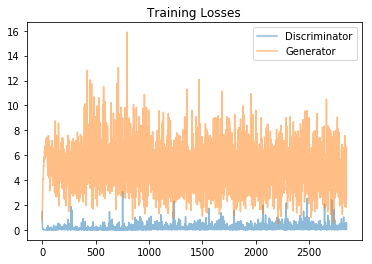

In [23]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [24]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [25]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

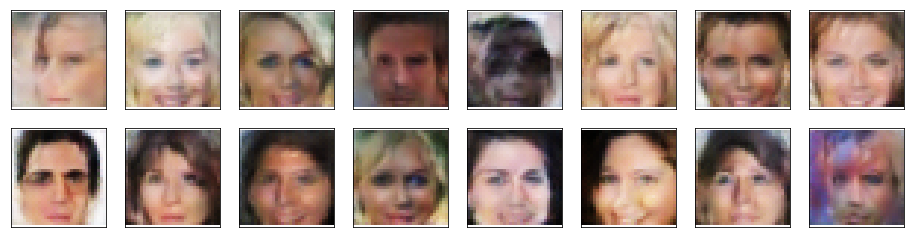

In [26]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** Yes, we cannot find typical characteristics of colored people, which reflects that the data-set is biased towards western faces. Seems like we can see the same canvas and nose on multiple images, that suggests that the features learned by the generator is limited. From the training loss, it seems like both the generator and the discriminator is improving, so the model could possibly run for a lot more epochs and improve even further.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.